In [1]:
import os
os.chdir('./vehicle_dataset_public/')

In [3]:
# import library for table-view representation and to operate with data more easy
import pandas as pd
# input files for vehicle: 
# fuelLevel (T), ingection (T), refueling2 (T), speedAndHeight (T), tachometer (T)

In [7]:
# данные по уровню топлива (непрерывный признак)
df_test = pd.read_csv('./vehicle1_fuelLevel_public.csv', sep=';')
df_test.dtypes

DTIME      object
BEVALUE    object
dtype: object

In [8]:
# данные по зажиганию (бинарный признак)
pd.read_csv('./vehicle1_refueling2_public.csv', sep=';')

,TSID,STARTDATE,ENDDATE,STARTLEVEL,ENDLEVEL
0,1,2020-01-16 11:02:40,2020-01-16 13:20:40,"46,7","38,4"
1,1,2020-01-16 13:20:40,2020-01-16 13:25:46,"38,4","56,7"
2,1,2020-01-17 09:05:49,2020-01-17 12:14:10,"56,3",51
3,1,2020-01-17 14:45:48,2020-01-17 16:12:27,51,"43,9"
4,1,2020-01-20 09:44:03,2020-01-20 12:44:07,"43,9","23,5"
...,...,...,...,...,...
98,1,2020-06-26 17:13:03,2020-06-26 18:57:03,"49,3","39,2"
99,1,2020-06-26 18:57:03,2020-06-26 19:04:00,"39,2","59,7"
100,1,2020-06-26 19:04:00,2020-06-26 21:20:41,"59,7","32,2"
101,1,2020-06-26 22:00:39,2020-06-27 00:11:16,"32,2","7,3"


In [10]:
! cat ./../readme_from_authors.txt



























В названиях файлов TSID означает идентификатор ТС.

In [10]:
# Скорость, ключ зажигания (бинарный признак), высота над уровнем моря и скорость передвижения
# , скорость вращения двигателя (об/мин), 

In [11]:
import pandas as pd

In [32]:
# get all files with vehicle word in name
filenames = [filename for filename in os.listdir() if filename.find('vehicle') != -1]

In [33]:
def get_unique_vehicles_sensors(filenames):
    vehicles, sensors = set(), set()
    for filename in filenames:
        vehicle_name, sensor_type, _ = filename.split('_')
        vehicles.add(vehicle_name)
        sensors.add(sensor_type)
    return list(vehicles), list(sensors)

In [34]:
vehicles, sensors = get_unique_vehicles_sensors(filenames)

In [86]:
# sort vehicle names and sensor types
vehicles.sort()
sensors.sort()

# show it
vehicles, sensors

(['vehicle1', 'vehicle19', 'vehicle28', 'vehicle3', 'vehicle5'],
 ['fuelLevel', 'ingection', 'refueling2', 'speedAndHeight', 'tachometer'])

In [89]:
vehicles_data = pd.Series()
for vehicle_name in vehicles:
    vehicle = pd.Series()
    for sensor in sensors:
        sensor_df = pd.read_csv('_'.join([vehicle_name, sensor, 'public.csv']), sep=';')
        vehicle[sensor] = sensor_df
    vehicles_data[vehicle_name] = vehicle

In [90]:
def convert_number(num_as_string):
    """
        function converts numbers from string format N,n (replace all commas with dots) 
        to pandas Series float value format N.n (real number)
    """

    return num_as_string.str.replace(',', '.').astype('float')


def convert_date(date_as_string):
    """
        function converts date from string to datetime64 pandas date format
    """
    
    return date_as_string.astype('datetime64')


# replace commas with dots and change type from object to float64
for vehicle in vehicles:
    # fuelLevel dataset preproccess
    for sensor in sensors:
        sensor_data = vehicles_data[vehicle][sensor]
        values = sensor_data.columns
        for value in values:
            # three types: int | float | date
            # need to become: int->int str->float (if BEVALUE) and not int64 already
            # check correctness using print(vehicle, sensor, sensor_data, value)
            if sensor_data[value].dtype == 'object':
                date_like_columns = ['DTIME', 'STARTDATE', 'ENDDATE']
                if value in date_like_columns:
                    sensor_data[value] = convert_date(sensor_data[value])
                else:
                    sensor_data[value] = convert_number(sensor_data[value])
            # if not object do nothing (cause int64 -> (goes to) int64 by default)

In [91]:
vehicles_data['vehicle1'].fuelLevel.dtypes

DTIME      datetime64[ns]
BEVALUE           float64
dtype: object

In [92]:
# generate some new features such as max_fuel
for vehicle in vehicles:
    # fuel level features
    current_vehicle = vehicles_data[vehicle]
    df = current_vehicle.fuelLevel
    current_vehicle['max_fuel'] = df.BEVALUE.max()
    
    # height features
    df = current_vehicle.speedAndHeight
    current_vehicle['max_height'] = df.HEIGHT.max()
    current_vehicle['min_height'] = df.HEIGHT.min()
    current_vehicle['avg_height'] = df.HEIGHT.mean()
    current_vehicle['range_height'] = df.HEIGHT.max() - df.HEIGHT.min()
    
    # speed features
    vehicles_data[vehicle]['max_speed'] = df.SPEED.max()
    # vehicles_data[vehicle]['min_speed'] = df.SPEED.min() -- not informative cause min is 0 for all
    vehicles_data[vehicle]['avg_speed'] = df.SPEED.mean()
    # vehicles_data[vehicle]['range_speed'] = df.SPEED.max() - df.SPEED.min() -- not informative cause max_speed 

Анализ максимального уровня топлива в баках за весь предоставленный период времени может свидетельствовать о том, что vehicle28 и vehicle1 с максимальным объемом в 60 литров с больой вероятностью являются легковыми автомобилями.

Таким же является vehicle5 с максимальным объемом в 73,5 литра.

Транспортное средство с идентификатором vehicle19 относится к типу (???)

vehicle3 -- фура с самым большим из представленных баков, предназначена для транспортировки грузов на дальние расстояния, магистральный тягач типа MAN, 279.8 (280) литров.

In [104]:
# make dataframe with new features
vehicles_df = pd.DataFrame()
for vehicle in vehicles:
    # get only features generated by us
    generated_features = list(set(vehicles_data[vehicle].index) - set(sensors))
    vehicles_df[vehicle] = vehicles_data[vehicle][generated_features]

In [151]:
vehicles_data['vehicle1'].fuelLevel.BEVALUE

0         0.0
1         0.0
2         0.0
3        49.7
4        49.9
         ... 
19027    54.0
19028    54.2
19029    54.0
19030    54.2
19031    54.4
Name: BEVALUE, Length: 19032, dtype: float64

In [105]:
vehicles_df

,vehicle1,vehicle19,vehicle28,vehicle3,vehicle5
min_height,-1503.6,-46.6,-2561.8,-79.7,-3228.2
avg_speed,52.3975,1.98549,42.1614,29.6963,59.0354
avg_height,37.0444,81.3893,61.5954,56.7928,52.983
range_height,3697,2859.4,2937.1,246.8,6486.9
max_height,2193.4,2812.8,375.3,167.1,3258.7
max_fuel,60,95,60,279.8,73.5
max_speed,129,57,122,227,132


In [152]:
vdft = vehicles_df.transpose()
vdft

,min_height,avg_speed,avg_height,range_height,max_height,max_fuel,max_speed
vehicle1,-1503.6,52.3975,37.0444,3697,2193.4,60,129
vehicle19,-46.6,1.98549,81.3893,2859.4,2812.8,95,57
vehicle28,-2561.8,42.1614,61.5954,2937.1,375.3,60,122
vehicle3,-79.7,29.6963,56.7928,246.8,167.1,279.8,227
vehicle5,-3228.2,59.0354,52.983,6486.9,3258.7,73.5,132


In [108]:
from matplotlib import pyplot as plt

In [156]:
dp = list(vdft[['max_fuel', 'avg_speed']].values)
dp

[array([60.0, 52.397460664742574], dtype=object),
 array([95.0, 1.985494106980961], dtype=object),
 array([60.0, 42.161399705980195], dtype=object),
 array([279.8, 29.696296296296296], dtype=object),
 array([73.5, 59.03544883970601], dtype=object)]

In [157]:
X = [el[0] for el in dp]
y = [el[1] for el in dp]

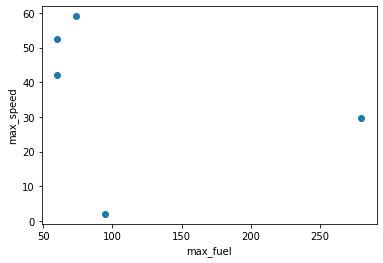

<Figure size 864x864 with 0 Axes>

In [158]:
plt.scatter(X, y)
plt.xlabel('max_fuel')
plt.ylabel('max_speed')
plt.figure(figsize=(12,12))
plt.show()

Признаки, которые нужно добавить для классификации ТС:
* число заправок в час / периодичность заправок / 

Заправки/сливы мы определили?

**Оконные вещи:**
* Скачки скорости
* Длительность сессии неспешной езды (или что-то типа)
* Длительность ускорений (средняя или медианная)
* Длительность 

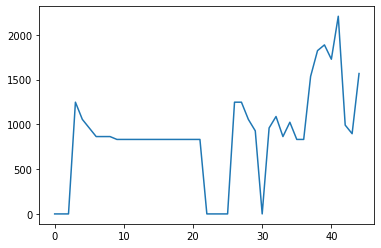

In [159]:
plt.plot(list(vehicles_data['vehicle1'].tachometer.BEVALUE[:45]))

In [257]:
for vehicle in vehicles:
    fuel_values = list(vehicles_data[vehicle].fuelLevel.BEVALUE)
    
    defuel_indexes = []
    defuel_amounts = []
    fuel_indexes = []
    fuel_amounts = []
    
    DEFUEL_THRESHOLD = 10 # litres in min
    FUEL_THRESHOLD = 20 # litres in min
    
    for i in range(0, len(fuel_values) - 1):
        # defuels
        if (fuel_values[i] - fuel_values[i+1] > DEFUEL_THRESHOLD):
            defuel_indexes.append(i)
            # sliv_indexes.append(i+1)
            defuel_amounts.append(fuel_values[i])

        # fuels
        if ((fuel_values[i+1] - fuel_values[i]) > FUEL_THRESHOLD):
            fuel_indexes.append(i+1)
            fuel_amounts.append(fuel_values[i+1])
    
    # add this info to vehicle data
    current_vehicle = vehicles_data[vehicle]
    df = current_vehicle.fuelLevel
    current_vehicle['fuel_periods'] = df.DTIME[fuel_indexes]
    current_vehicle['defuel_periods'] = df.DTIME[defuel_indexes]
    
    # add info about sum of fuels / defuels
    current_vehicle['sum_fuel'] = sum(fuel_amounts)
    current_vehicle['sum_defuel'] = sum(defuel_amounts)

In [263]:
vehicles_data['vehicle3']

fuelLevel                            DTIME  BEVALUE
0    2020-01...
ingection                            DTIME  BEVALUE
0    2020-01...
refueling2            TSID           STARTDATE             ENDDA...
speedAndHeight                       DTIME  SPEED  HEIGHT
0    2...
tachometer                           DTIME  BEVALUE
0    2020-01...
max_fuel                                                      279.8
max_height                                                    167.1
min_height                                                    -79.7
avg_height                                                  56.7928
range_height                                                  246.8
max_speed                                                       227
avg_speed                                                   29.6963
fuel_periods      1      2020-01-09 08:40:43
273    2020-02-10 0...
defuel_periods    271    2020-01-09 14:36:57
954    2020-02-14 1...
sum_fuel                                        

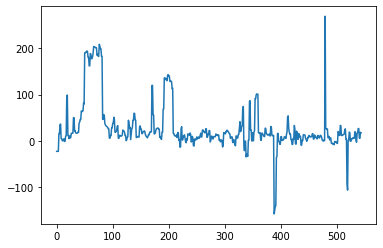

In [200]:
plt.plot(list(vehicles_data['vehicle1'].speedAndHeight.HEIGHT[sliv_indexes]))

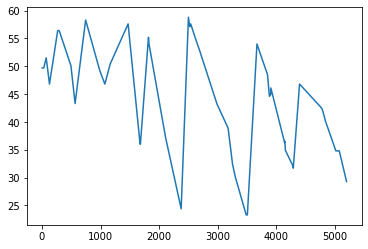

In [239]:
plt.plot(vehicles_data['vehicle1'].fuelLevel.BEVALUE[fuel_indexes[:50]])

In [216]:
vehicles_data['vehicle1'].refueling2

,TSID,STARTDATE,ENDDATE,STARTLEVEL,ENDLEVEL
0,1,2020-01-16 11:02:40,2020-01-16 13:20:40,46.7,38.4
1,1,2020-01-16 13:20:40,2020-01-16 13:25:46,38.4,56.7
2,1,2020-01-17 09:05:49,2020-01-17 12:14:10,56.3,51.0
3,1,2020-01-17 14:45:48,2020-01-17 16:12:27,51.0,43.9
4,1,2020-01-20 09:44:03,2020-01-20 12:44:07,43.9,23.5
...,...,...,...,...,...
98,1,2020-06-26 17:13:03,2020-06-26 18:57:03,49.3,39.2
99,1,2020-06-26 18:57:03,2020-06-26 19:04:00,39.2,59.7
100,1,2020-06-26 19:04:00,2020-06-26 21:20:41,59.7,32.2
101,1,2020-06-26 22:00:39,2020-06-27 00:11:16,32.2,7.3


In [241]:
vehicles_data['vehicle1'].fuelLevel.DTIME[fuel_indexes]

3       2020-01-09 10:05:26
25      2020-01-14 09:34:09
30      2020-01-14 09:56:57
72      2020-01-14 10:41:03
128     2020-01-16 11:02:40
                ...        
18509   2020-06-25 18:46:18
18614   2020-06-26 16:44:29
18634   2020-06-26 17:13:03
18740   2020-06-26 19:04:00
19003   2020-06-27 00:22:37
Name: DTIME, Length: 288, dtype: datetime64[ns]